# Using embeddings for semantic search

Transformer-based language models represent each token in a span of text as an ***embedding vector***. It turns out that **one can “pool” the individual embeddings to create a vector representation for whole sentences, paragraphs, or (in some cases) documents**. These embeddings can then be used to find similar documents in the corpus by computing the dot-product similarity (or some other similarity metric) between each embedding and returning the documents with the greatest overlap.

In this Notebook we’ll use embeddings to develop a semantic search engine. These search engines offer several advantages over conventional approaches that are based on matching keywords in a query with the documents.

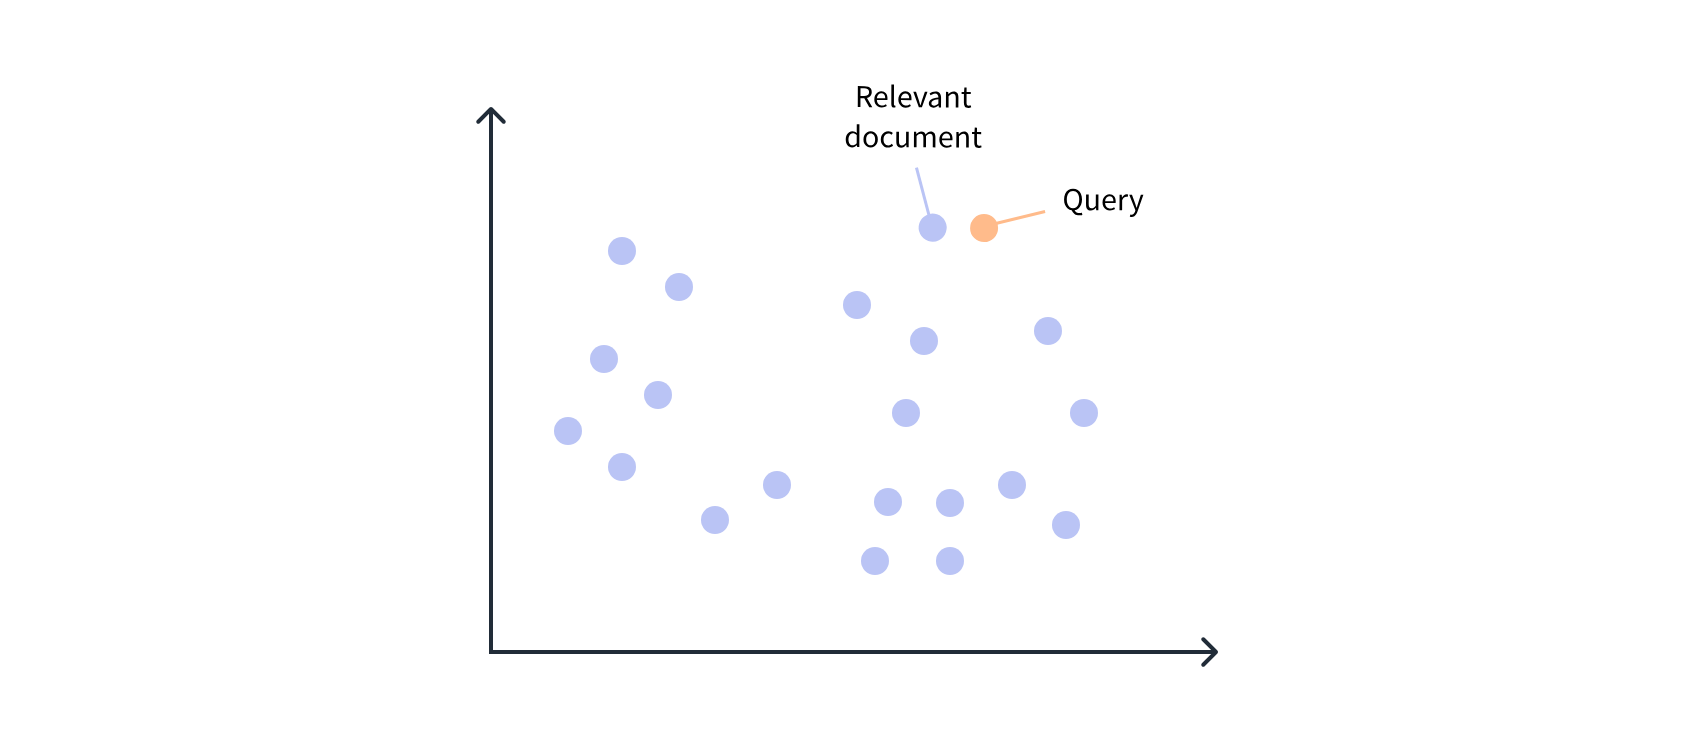

# Loading and preparing the dataset

The first thing we need to do is download our dataset, so let’s use `load_dataset()` function as usual:

In [1]:
from datasets import load_dataset

issues_dataset = load_dataset("lewtun/github-issues", split="train")
issues_dataset

Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments', 'created_at', 'updated_at', 'closed_at', 'author_association', 'active_lock_reason', 'pull_request', 'body', 'timeline_url', 'performed_via_github_app', 'is_pull_request'],
    num_rows: 3019
})

## Preprocessing

Here we’ve specified the default train split in load_dataset(), so it returns a Dataset instead of a DatasetDict. The first order of business is to filter out the pull requests, as these tend to be rarely used for answering user queries and will introduce noise in our search engine. As should be familiar by now, we can use the `Dataset.filter()` function to exclude these rows in our dataset. While we’re at it, let’s also filter out rows with no comments, since these provide no answers to user queries:

In [2]:
issues_dataset = issues_dataset.filter(
    lambda x: (
        x["is_pull_request"] == False and
        len(x["comments"]) > 0
    )
)
issues_dataset

Dataset({
    features: ['url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments', 'created_at', 'updated_at', 'closed_at', 'author_association', 'active_lock_reason', 'pull_request', 'body', 'timeline_url', 'performed_via_github_app', 'is_pull_request'],
    num_rows: 808
})

From a search perspective, the most informative columns are `title`, `body`, and `comments`, while `html_url` provides us with a link back to the source issue. Let’s use the Dataset.`remove_columns()` function to drop the rest:

In [3]:
columns = issues_dataset.column_names
columns_to_keep = ["title", "body", "html_url", "comments"]
columns_to_remove = set(columns_to_keep).symmetric_difference(columns)
issues_dataset = issues_dataset.remove_columns(columns_to_remove)
issues_dataset

Dataset({
    features: ['html_url', 'title', 'comments', 'body'],
    num_rows: 808
})

## Augmenting

To create our embeddings we’ll augment each comment with the issue’s title and body, since these fields often include useful contextual information. Because our `comments` column is currently a list of comments for each issue, we need to “explode” the column so that each row consists of an (`html_url`, `title`, `body`, `comment`) tuple. In Pandas we can do this with the [`DataFrame.explode() function`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html), which creates a new row for each element in a list-like column, while replicating all the other column values. To see this in action, let’s first switch to the Pandas `DataFrame` format:

In [4]:
issues_dataset.set_format("pandas")
df = issues_dataset[:]  # Make a copy of the dataset as DataFrame

In [5]:
df["comments"][0].tolist()  # We can see there are several comments

['Cool, I think we can do both :)',
 '@lhoestq now the 2 are implemented.\r\n\r\nPlease note that for the the second protection, finally I have chosen to protect the master branch only from **merge commits** (see update comment above), so no need to disable/re-enable the protection on each release (direct commits, different from merge commits, can be pushed to the remote master branch; and eventually reverted without messing up the repo history).']

When we **explode df**, we expect to **get one row for each of these comments**. Let’s check if that’s the case:

In [6]:
print(f"Len dataframe: {len(df)}")
comments_df = df.explode("comments", ignore_index=True)
print(f"Len dataframe: {len(comments_df)}")
comments_df.head(4)

Len dataframe: 808
Len dataframe: 2964


,html_url,title,comments,body
0,https://github.com/huggingface/datasets/issues...,Protect master branch,"Cool, I think we can do both :)",After accidental merge commit (91c55355b634d0d...
1,https://github.com/huggingface/datasets/issues...,Protect master branch,@lhoestq now the 2 are implemented.\r\n\r\nPle...,After accidental merge commit (91c55355b634d0d...
2,https://github.com/huggingface/datasets/issues...,Backwards compatibility broken for cached data...,Hi ! I guess the caching mechanism should have...,## Describe the bug\r\nAfter upgrading to data...
3,https://github.com/huggingface/datasets/issues...,Backwards compatibility broken for cached data...,"If it's easy enough to implement, then yes ple...",## Describe the bug\r\nAfter upgrading to data...


Great, we can see the rows have been replicated, with the `comments` column containing the individual comments! Now that we’re finished with Pandas, we can quickly **switch** back to a `Dataset` by loading the `DataFrame` in memory:

In [7]:
from datasets import Dataset

comments_dataset = Dataset.from_pandas(comments_df)
comments_dataset

Dataset({
    features: ['html_url', 'title', 'comments', 'body'],
    num_rows: 2964
})

Now that we have one comment per row, let’s create a new comments_length column that contains the **number of words per comment**:

In [8]:
comments_dataset = comments_dataset.map(
    lambda x: {"comment_length": len(x["comments"].split())}
)

Map:   0%|          | 0/2964 [00:00<?, ? examples/s]

We can use this new column to **filter out short comments**, which typically include things like “cc @lewtun” or “Thanks!” that are not relevant for our search engine. There’s no precise number to select for the filter, but around 15 words seems like a good start:

In [9]:
comments_dataset = comments_dataset.filter(lambda x: x["comment_length"] > 15)
comments_dataset

Filter:   0%|          | 0/2964 [00:00<?, ? examples/s]

Dataset({
    features: ['html_url', 'title', 'comments', 'body', 'comment_length'],
    num_rows: 2175
})

Having cleaned up our dataset a bit, let’s **concatenate** the issue `title`, `description`, and `comments` together in a new **`text`** column. As usual, we’ll write a simple function that we can pass to `Dataset.map()`:

In [10]:
def concatenate_text(example):
    return {
        "text": example["title"]
        + " \n "
        + example["body"]
        + " \n "
        + example["comments"]
    }


comments_dataset = comments_dataset.map(concatenate_text)

Map:   0%|          | 0/2175 [00:00<?, ? examples/s]

# Creating text embeddings

All we need to do is pick a suitable checkpoint to load the model from. Fortunately, there’s a library called sentence-transformers that is dedicated to creating embeddings. As described in the library’s [documentation](https://www.sbert.net/examples/applications/semantic-search/README.html#symmetric-vs-asymmetric-semantic-search), our use case is an example of ***asymmetric semantic search*** because we have a short query whose answer we’d like to find in a longer document, like a an issue comment. The handy [model overview table](https://www.sbert.net/docs/pretrained_models.html#model-overview) in the documentation indicates that the `multi-qa-mpnet-base-dot-v1` checkpoint has the best performance for semantic search, so we’ll use that for our application. We’ll also load the tokenizer using the same checkpoint:

In [11]:
from transformers import AutoTokenizer, AutoModel

model_ckpt = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

To speed up the embedding process, it helps to place the model and inputs on a GPU **device**, so let’s do that now:

In [12]:
import torch

device = torch.device("cuda")
model.to(device)
print(f"Using device: {device}")

Using device: cuda


As we mentioned earlier, we’d like to represent each entry in our GitHub issues corpus as a single vector, so we **need to “pool” or average our token embeddings** in some way. One popular approach is to perform CLS pooling on our model’s outputs, where we simply collect the last hidden state for the special `[CLS] token`. The following function does the trick for us:

In [30]:
def cls_pooling(model_output):
    # # (batch_size, tokens, hidden_size)
    return model_output.last_hidden_state[:, 0, :]  # CLS token is first token

Next, we’ll create a helper function that will tokenize a list of documents, place the tensors on the GPU, feed them to the model, and finally apply CLS pooling to the outputs:

In [31]:
def get_embeddings(text_list):
    encoded_input = tokenizer(
        text_list, padding=True, truncation=True, return_tensors="pt"
    )
    # Move input tensors to the device
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    # Get the model embeddings
    model_output = model(**encoded_input)
    # Pool the embeddings into a single vector
    embeddings = cls_pooling(model_output)
    embeddings = embeddings.detach().cpu().numpy()
    return embeddings


We can test the function works by feeding it the first text entry in our corpus and inspecting the output shape:

In [32]:
embedding = get_embeddings(comments_dataset["text"][0])
embedding.shape

(1, 768)

Great, we’ve converted the first entry in our corpus into a 768-dimensional vector! We can use `Dataset.map()` to apply our `get_embeddings()` function to each row in our corpus, so let’s create a new embeddings column as follows:

In [16]:
embeddings_dataset = comments_dataset.map(
    lambda x: {"embeddings": get_embeddings(x["text"])},
    batched=True,
    batch_size=8,
)

Map:   0%|          | 0/2175 [00:00<?, ? examples/s]

Notice that we’ve converted the **embeddings to NumPy arrays** — that’s because Hugging Face Datasets requires this format when we try to index them with FAISS, which we’ll do next.

# Using FAISS for efficient similarity search

Now that we have a dataset of embeddings, **we need some way to search over them**. To do this, we’ll use a special data structure in Hugging Face Datasets called a ***FAISS index***. [FAISS](https://faiss.ai/) (short for Facebook AI Similarity Search) is a library that provides efficient algorithms to quickly search and cluster embedding vectors.

The basic idea behind FAISS is to create a special data structure called an index that allows one to find which embeddings are similar to an input embedding. Creating a FAISS index in Hugging Face Datasets is simple — we use the `Dataset.add_faiss_index()` function and specify which column of our dataset we’d like to index:

In [17]:
embeddings_dataset.add_faiss_index(column="embeddings")

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset({
    features: ['html_url', 'title', 'comments', 'body', 'comment_length', 'text', 'embeddings'],
    num_rows: 2175
})

We can now **perform queries** on this index by doing a nearest neighbor lookup with the **`Dataset.get_nearest_examples()`** function. Let’s test this out by first embedding a question as follows:

In [18]:
question = "How can I load a dataset offline?"
question_embedding = get_embeddings([question])
question_embedding.shape

(1, 768)

Just like with the documents, we now have a 768-dimensional vector representing the query, which we can compare against the whole corpus to find the most similar embeddings:

In [19]:
scores, samples = embeddings_dataset.get_nearest_examples(
    "embeddings", question_embedding, k=5
)

The `Dataset.get_nearest_examples()` function returns **a tuple of scores that rank the overlap between the query and the document, and a corresponding set of samples (here, the 5 best matches)**. Let’s collect these in a `pandas.DataFrame` so we can easily sort them:

In [22]:
import pandas as pd

samples_df = pd.DataFrame.from_dict(samples)
samples_df["scores"] = scores
samples_df.sort_values("scores", ascending=False, inplace=True)

In [23]:
for _, row in samples_df.iterrows():
    print(f"COMMENT: {row.comments}")
    print(f"SCORE: {row.scores}")
    print(f"TITLE: {row.title}")
    print(f"URL: {row.html_url}")
    print("=" * 50)
    print()

COMMENT: Requiring online connection is a deal breaker in some cases unfortunately so it'd be great if offline mode is added similar to how `transformers` loads models offline fine.

@mandubian's second bullet point suggests that there's a workaround allowing you to use your offline (custom?) dataset with `datasets`. Could you please elaborate on how that should look like?
SCORE: 25.50502586364746
TITLE: Discussion using datasets in offline mode
URL: https://github.com/huggingface/datasets/issues/824

COMMENT: The local dataset builders (csv, text , json and pandas) are now part of the `datasets` package since #1726 :)
You can now use them offline
```python
datasets = load_dataset('text', data_files=data_files)
```

We'll do a new release soon
SCORE: 24.55552101135254
TITLE: Discussion using datasets in offline mode
URL: https://github.com/huggingface/datasets/issues/824

COMMENT: I opened a PR that allows to reload modules that have already been loaded once even if there's no internet